# Nelson Siegel Svensson - Introduction

Note 02 on Robust Calibration to follow

The Nelson-Siegel and its extension Nelson-Siegel-Svensson are two of the most popular yield curve models

They are very useful when we do not have nicely spaced bond quotes data to build the discounting factors.

Sometimes up until certain maturities there are two many bonds compared with the number of maturities, and not sufficiently bonds thereafter. Very often, there are multiple bonds maturing in the same months.

If what we need to price a bond is the discounting factor 

\begin{equation}
Z(0,t) =  exp^{-r(0,t)t}
\end{equation}

then we can postulate a parametric function for the zero rate  $r(0,t)$, and use bond prices to estimate those parameters.

In the Nelson Siegel Svensson model, the zero rate follows the following parametric equation:

\begin{equation}
r(0,t) = \beta_0 + \left(\beta_1 + \beta_2\right)\left(\frac{1-e^{\left(\frac{-t}{T_1}\right)}}{t/T_1} \right) -
\beta_2 \left(e^{\frac{-t}{T_1}} \right)+ 
\beta_3 \left( \frac{1-e^{\left(\frac{-t}{T_2}\right)}}{t/T_2} -e^{\frac{-t}{T_2}} \right)
\end{equation}


where:

-  $r(0,t)$: zero rate with maturity $t$
-  $\beta_0$: level parameter, the long term rate
-  $\beta_1$: slope parameter, the spread short/long-term
-  $\beta_2$: first curvature or hump parameter
-  $\beta_3$: second curvature or hump parameter which allows for a better fit at long maturities

-  $T_1$: scale parameter which affects both the slope and first curvature $\beta_1$ and $\beta_2$
-  $T_2$: scale parameter for the second hump parameter $\beta_3$

The way we proceed is by selecting the given set of NSS's parameters which minimizes the following quantity

$$ \sum_{i=1}^{N}\left(P^{i,NSS}(0,t)-P^{i}(0,t)\right) $$


where:

$P^{i,NSS}(0,t)$  is the discounted value of the bond $i$ cash flows and

$P^{i}(0,t)$ is dirty price (quoted clean price + accrued interest) of the same bond $i$

$N$ is the number of bonds with quotes

In this notebook, we want to try to calibrate the NSS parameters to a set of bond prices made available to us. The prices are old, infact they date back to december 1st 2000.

There is a lot of research on the algos that should be used when calibrating the NSS model, and also on some of the issues and challenges, one being the multicollinearity, and a second the calibration results strongly depend on the starting values.

However, as this is our first notebook on the topic, we are not going to use the most advanced algo, instead we are going to use the minimize object available in python via the library "scipy.optimize".

One warning: When preparing this exercise the calibration results were often poor, and due to the starting  values. 
We plan to write a second notebook where we deal with the starting value issues, so to make our algo more robust and of practical use!

We start by importing the python libraries we need

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
%matplotlib inline

Let's import our data set:

CashFlows and Prices

In [2]:
CashFlows = pd.read_excel ('BondPrices_DB.xlsx', sheet_name='CashFlows')
print (CashFlows.head(2))
print (CashFlows.tail(2))

        Time  Bond1  Bond2  Bond3  Bond4  Bond5  Bond6  Bond7  Bond8  Bond9  \
0 2000-12-02      0      0      0      0      0      0      0      0      0   
1 2000-12-03      0      0      0      0      0      0      0      0      0   

    ...     Bond120  Bond121  Bond122  Bond123  Bond124  Bond125  Bond126  \
0   ...           0      0.0      0.0      0.0      0.0      0.0      0.0   
1   ...           0      0.0      0.0      0.0      0.0      0.0      0.0   

   Bond127  Bond128  Bond129  
0      0.0      0.0      0.0  
1      0.0      0.0      0.0  

[2 rows x 130 columns]
          Time  Bond1  Bond2  Bond3  Bond4  Bond5  Bond6  Bond7  Bond8  Bond9  \
211 2029-02-15      0      0      0      0      0      0      0      0      0   
212 2029-08-15      0      0      0      0      0      0      0      0      0   

       ...     Bond120  Bond121  Bond122  Bond123  Bond124  Bond125  Bond126  \
211    ...           0      0.0      0.0      0.0      0.0      0.0      0.0   
212    ..

Please also note that the time when bonds cash flows occur are not at constant intervals  

In [3]:
row, col = CashFlows.shape
print (row)
print (col)
# there are 129 bonds (columns), with 213 cash flows items (rows) 

213
130


In [4]:
# In this print: the first two bonds are Zero Coupon Bonds, whereas the last two are Coupon Bonds
BondPrices = pd.read_excel (r'BondPrices_DB.xlsx', sheet_name='Prices')
print (BondPrices.head(2))
print (BondPrices.tail(2))

    Name  Dirty Price  Clean Price  AccruedInterest  Coupon   Maturity
0  Bond1    99.897834    99.897834              0.0     0.0 2000-12-07
1  Bond2    99.783604    99.783604              0.0     0.0 2000-12-14
        Name  Dirty Price  Clean Price  AccruedInterest  Coupon   Maturity
127  Bond128    94.943105    93.402344         1.540761   5.250 2029-02-15
128  Bond129   107.766304   105.968750         1.797554   6.125 2029-08-15


In [5]:
print (BondPrices.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 6 columns):
Name               129 non-null object
Dirty Price        129 non-null float64
Clean Price        129 non-null float64
AccruedInterest    129 non-null float64
Coupon             129 non-null float64
Maturity           129 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 6.1+ KB
None


We need to add a column for the time lapsing from "today" which is 1st of December 2000 until the bond pays a coupon or matures

In [6]:
from datetime import date
first_date = date(2000, 12, 1)
CashFlows["timeDiff"] = (CashFlows["Time"] - first_date)
CashFlows["timeDiff"] = CashFlows["timeDiff"]/np.timedelta64(1,'D')
CashFlows["timeDiff"] = CashFlows["timeDiff"]/365.0
print (CashFlows.head(4))

        Time  Bond1  Bond2  Bond3  Bond4  Bond5  Bond6  Bond7  Bond8  Bond9  \
0 2000-12-02      0      0      0      0      0      0      0      0      0   
1 2000-12-03      0      0      0      0      0      0      0      0      0   
2 2000-12-04      0      0      0      0      0      0      0      0      0   
3 2000-12-05      0      0      0      0      0      0      0      0      0   

     ...     Bond121  Bond122  Bond123  Bond124  Bond125  Bond126  Bond127  \
0    ...         0.0      0.0      0.0      0.0      0.0      0.0      0.0   
1    ...         0.0      0.0      0.0      0.0      0.0      0.0      0.0   
2    ...         0.0      0.0      0.0      0.0      0.0      0.0      0.0   
3    ...         0.0      0.0      0.0      0.0      0.0      0.0      0.0   

   Bond128  Bond129  timeDiff  
0      0.0      0.0  0.002740  
1      0.0      0.0  0.005479  
2      0.0      0.0  0.008219  
3      0.0      0.0  0.010959  

[4 rows x 131 columns]


From the BondPrices and CashFlows dataframes, we respectively need "Dirty Prices", "timeDiff" and all Cash Flows.

Let's import them into numpy arrays and also check they have the correct dimension

In [7]:
DirtyPrices= BondPrices["Dirty Price"].values
Maturities = BondPrices["Dirty Price"].values
TimeValue  = CashFlows["timeDiff"].values
CFs        = CashFlows[CashFlows.columns[1:130]].values

In [8]:
print (DirtyPrices.size)
print (TimeValue.size)
print (CFs.shape)

129
213
(213, 129)


They have the right size: There are 129 bonds with 213 cash flows. Some bonds have coupon payments occuring on the same date  

In case you want to see cash flows in an excel sheet, run this 

In [9]:
df = pd.DataFrame(CFs)
df.to_csv('Cashflows.csv')

We also calculate the YTM for each bond. We will need it later.  

Let's write a class to do that. 

In [10]:
class YTM(object):
    def __init__(self, DirtyPrice, times, CFs):
        self.times     = np.array(times)
        self.CFs       = np.array(CFs)
        self.size      = self.times.size
        self.DirtyPrice= DirtyPrice 
        self.df        = np.zeros(self.size)
        self.ytm       = 0.0
        
    def DF(self, ytm):
        for i, j in enumerate (self.times):
            self.df[i] = (1+ytm/2.0)**(-j * 2.0)
    
    def MyDirtyPrice(self):
        self.my_dirtyprice = self.df.dot(self.CFs)
    
    def loss(self, x):
        self.x = x
        self.DF(self.x)
        self.MyDirtyPrice()
        Tominimize      = 1000*(self.my_dirtyprice - self.DirtyPrice)
        return Tominimize**2
        
    def solve(self,x0 = np.random.rand(1)):
        self.opt_results = optimize.fmin(self.loss,x0=x0, disp=False)
        self.x           = self.opt_results[0]

Let's test on the last bond on our dataset

In [11]:
# The cash flows and price are the following
print (DirtyPrices[128])
print (CFs[:, 128])

107.7663043478261
[  0.       0.       0.       0.       0.       0.       0.       0.
   0.       0.       0.       0.       0.       0.       0.       0.
   0.       0.       0.       0.       3.0625   0.       0.       0.
   0.       0.       0.       0.       0.       0.       0.       0.
   0.       0.       0.       0.       0.       0.       0.       0.
   0.       0.       0.       0.       0.       0.       0.       3.0625
   0.       0.       0.       0.       0.       0.       0.       0.
   0.       0.       0.       0.       0.       0.       3.0625   0.
   0.       0.       0.       0.       0.       0.       0.       0.
   0.       0.       3.0625   0.       0.       0.       0.       0.
   0.       0.       0.       0.       0.       0.       0.       3.0625
   0.       0.       0.       0.       0.       0.       0.       0.
   3.0625   0.       0.       0.       3.0625   0.       0.       0.
   3.0625   0.       0.       0.       3.0625   0.       0.       0.
   3.062

In [12]:
ytm = YTM(DirtyPrices[128], TimeValue, CFs[:, 128])
ytm.solve()
print (ytm.x)
print (ytm.my_dirtyprice)
print (DirtyPrices[128])

0.056961299200351756
107.76632424553891
107.7663043478261


For each bond, let's calculate the YTM, given its Dirty Price

In [13]:
ytmArray       = np.zeros(DirtyPrices.size)
DirtyPrice_ytm = np.zeros(DirtyPrices.size)
for i in range(DirtyPrices.size):    
    ytm               = YTM(DirtyPrices[i], TimeValue, CFs[:, i])
    ytm.solve()
    ytmArray[i]       = (ytm.x)
    DirtyPrice_ytm[i] = (ytm.my_dirtyprice)

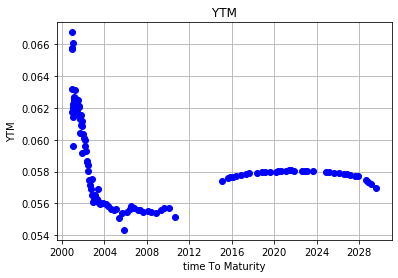

In [14]:
plt.plot(BondPrices["Maturity"], ytmArray, 'bo')
plt.xlabel('time To Maturity')  
plt.ylabel('YTM')
plt.grid(True)
plt.title(" YTM ");
plt.show()

Let's add ytm's and Dirty Price calculated with ytm into the "BondPrices" dataframe and check they are all ok

In [15]:
BondPrices["YTM"]            = ytmArray
BondPrices["DirtyPrice_YTM"] = DirtyPrice_ytm

In [16]:
# Are there any error?
print (np.round((np.sum(BondPrices["DirtyPrice_YTM"] - BondPrices["Dirty Price"])),5))

1e-05


In [17]:
print (BondPrices.head(2))
print (BondPrices.tail(2))

    Name  Dirty Price  Clean Price  AccruedInterest  Coupon   Maturity  \
0  Bond1    99.897834    99.897834              0.0     0.0 2000-12-07   
1  Bond2    99.783604    99.783604              0.0     0.0 2000-12-14   

        YTM  DirtyPrice_YTM  
0  0.063161       99.897842  
1  0.061758       99.783613  
        Name  Dirty Price  Clean Price  AccruedInterest  Coupon   Maturity  \
127  Bond128    94.943105    93.402344         1.540761   5.250 2029-02-15   
128  Bond129   107.766304   105.968750         1.797554   6.125 2029-08-15   

          YTM  DirtyPrice_YTM  
127  0.057198       94.943109  
128  0.056961      107.766324  


Let's write a class for the Nelson Siegel Svensson algo

In [18]:
class NelsonSiegelSvensson():
    def __init__(self, time_, Cashflows_, Prices_):
        self.time      = np.asarray(time_)
        self.Cashflows = np.asarray(Cashflows_)
        self.Prices    = np.asarray(Prices_)
        self.r         = np.zeros(self.time.size)
        self.df        = np.zeros(self.time.size)
                
        # DO NOT CHANGE them!!
        self.initialguess = [6278.30,-6278.30,-6291.28,0.70906,27056.5 ,20.2312]
        
        self.w = np.zeros(6)
    
    def UpdateWs(self, param):
        self.w = param
    
    def set_ws(self,w_):
        self.w = w_
        
    def DF(self):
        self.df = np.exp(-self.r * self.time)        
        
    def zerorate(self, t):        
        return self.w[0] + (self.w[1] + self.w[2])*(1-np.exp(-t/self.w[4]))/(t/self.w[4]) \
                - self.w[2]*np.exp(-t/self.w[4]) \
                + self.w[3] *( (1-np.exp(-t/self.w[5]))/(t/self.w[5]) - np.exp(-t/self.w[5]))

    def Zerorates(self, t):
        t      = self.time
        
        vfunc = np.vectorize(self.zerorate)
        
        self.r = vfunc(t)
    
    def loss(self, w):
        t      = self.time
        self.w = w
        self.Zerorates(t)
        self.DF()       
        Ax     = np.transpose(self.df).dot(self.Cashflows)
        error  = 1000*(self.Prices - Ax)
        
        return np.sum(error**2)
    
    def Calibrate(self):
        self.opt_results = optimize.minimize(self.loss,np.array(self.initialguess),jac=False,tol=1e-13,method='L-BFGS-B')
        self.w           = self.opt_results.x  

Let's check it works.

we instantiate an object of type "NelsonSiegelSvensson"

1 - We load a set of parameters

2 - We print the zero rate with a maturity of 1 year and 30 year

3 - we run the methods: Zerorates() and DF()

4 - and then multiply the object df by Cashflows. This should calculate Dirty Prices which we can compare with the Dirty Prices in our dataframe "BondPrices"

In [19]:
nss = NelsonSiegelSvensson(TimeValue, CFs, DirtyPrices )
# 1
nss.set_ws([6278.30,-6278.25,-6292.47,0.04387,27056.49,30.48])
# 2
print (nss.zerorate(1))
print (nss.zerorate(30))

0.050442755673682414
0.05492756131295528


In [20]:
# 3 
nss.Zerorates(TimeValue)
nss.DF()

# 4
Ax = np.transpose(nss.df).dot(nss.Cashflows)
BondPrices["DirtyPrice_NSS"] = Ax

In [21]:
# Are there any error?
print (np.round((np.sum(BondPrices["DirtyPrice_NSS"] - BondPrices["Dirty Price"])),5))

224.74065


CAN WE DO BETTER?

In [22]:
nss.Calibrate()

Print now the NSS parameters. We also use a function to apply print options locally

In [23]:
import contextlib

@contextlib.contextmanager
def printoptions(*args, **kwargs):
    original = np.get_printoptions()
    np.set_printoptions(*args, **kwargs)
    try:
        yield
    finally: 
        np.set_printoptions(**original)

x = nss.w
with printoptions(precision=3, suppress=True):
    print(x)

[ 6278.326 -6278.273 -6291.281     0.032 27056.563    20.237]


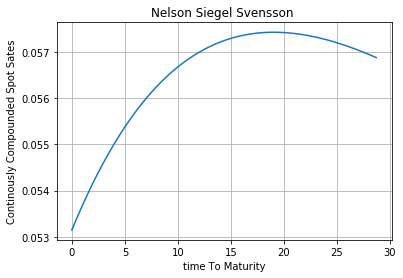

In [24]:
plt.plot(nss.time, nss.r, lw=1.5)
plt.xlabel('time To Maturity')  
plt.ylabel('Continously Compounded Spot Sates')
plt.grid(True)
plt.title("Nelson Siegel Svensson ");
plt.show()

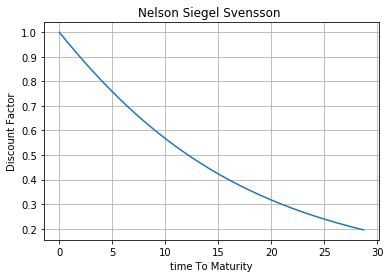

In [25]:
plt.plot(nss.time, nss.df, lw=1.5)
plt.xlabel('time To Maturity')  
plt.ylabel('Discount Factor')
plt.grid(True)
plt.title("Nelson Siegel Svensson ");
plt.show()

In [26]:
# Have we done better than before?
Ax = np.transpose(nss.df).dot(nss.Cashflows)
BondPrices["DirtyPrice_NSS"] = Ax
BondPrices["CleanPrice_NSS"] = BondPrices["DirtyPrice_NSS"] -  BondPrices["AccruedInterest"]  
BondPrices["CleanPrice_Diff"]= BondPrices["CleanPrice_NSS"] -  BondPrices["Clean Price"]
print (np.round((np.sum(BondPrices["DirtyPrice_NSS"] - BondPrices["Dirty Price"])),5))
# Yes!!

15.38384


In [27]:
print (np.max(BondPrices["CleanPrice_Diff"]))
print (np.max(BondPrices["CleanPrice_NSS"]))
print (np.max(BondPrices["Dirty Price"]))

0.6768508628748293
152.78587910872918
156.2391304347826


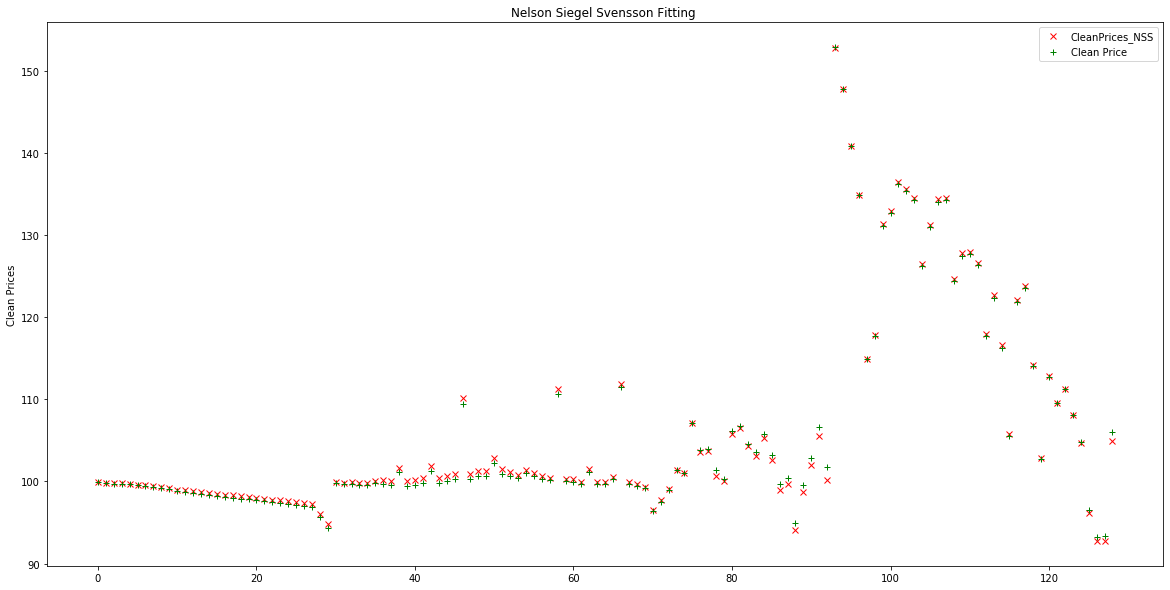

In [28]:
plt.figure(figsize=(20,10))
plt.plot(BondPrices["CleanPrice_NSS"],  'x', color='red', label ='CleanPrices_NSS')
plt.plot(BondPrices["Clean Price"],  '+', color='green'  ,label ='Clean Price')
plt.legend()
plt.ylabel('Bond No.')
plt.ylabel('Clean Prices')
plt.title("Nelson Siegel Svensson Fitting ");        
plt.show()

Now we can sort the bonds by the cheapest and the most expensive, by comparing the Clean Price vs the one we calculated with the NSS algo, called CleanPrice_NSS. For example we may want to short the most expensive and buy the cheapest, if you believe in the NSS model! 

In [29]:
BondPrices.sort_values(by='CleanPrice_Diff',ascending=1).head(5)

,Name,Dirty Price,Clean Price,AccruedInterest,Coupon,Maturity,YTM,DirtyPrice_YTM,DirtyPrice_NSS,CleanPrice_NSS,CleanPrice_Diff
92,Bond93,103.421875,101.734375,1.687500,5.750,2010-08-15,0.055137,103.421883,101.899984,100.212484,-1.521891
128,Bond129,107.766304,105.968750,1.797554,6.125,2029-08-15,0.056961,107.766324,106.711122,104.913567,-1.055183
91,Bond92,108.505265,106.597656,1.907609,6.500,2010-02-15,0.055688,108.505273,107.485623,105.578014,-1.019642
88,Bond89,95.151351,94.941406,0.209945,4.750,2008-11-15,0.055412,95.151334,94.255186,94.045241,-0.896165
89,Bond90,99.829031,99.585937,0.243094,5.500,2009-05-15,0.055606,99.829039,98.935527,98.692433,-0.893504


In [30]:
BondPrices.sort_values(by='CleanPrice_Diff',ascending=0).head(5)

,Name,Dirty Price,Clean Price,AccruedInterest,Coupon,Maturity,YTM,DirtyPrice_YTM,DirtyPrice_NSS,CleanPrice_NSS,CleanPrice_Diff
46,Bond47,113.615659,109.433594,4.182065,14.250,2002-02-15,0.059975,113.615655,114.292510,110.110445,0.676851
42,Bond43,101.593211,101.261719,0.331492,7.500,2001-11-15,0.061145,101.593219,102.221639,101.890147,0.628428
45,Bond46,102.338995,100.250000,2.088995,6.250,2002-01-31,0.060087,102.338988,102.965897,100.876902,0.626902
44,Bond45,102.643592,100.066406,2.577186,6.125,2001-12-31,0.060382,102.643602,103.260207,100.683022,0.616616
43,Bond44,99.817010,99.800781,0.016229,5.875,2001-11-30,0.060843,99.817014,100.432885,100.416656,0.615875
